# **Calculation of depletion forces in colloids and depletants**

## **Overview**

Depletion forces: Effective attractive force that arises when colloidal particle are suspended in dilute solution of depletants

## **Question**

Compute the mean force profile for colloids in a bath of depletants

### **Objectives**

- Demonstrate how to set up simulations of colloids in the solution of depletants
- Calculate the depletion force for a given separation between colloids and volume fraction of depletants

## **Workflow**

### **Import packgages**
Let's import the packages needed for the job.

In [20]:
import numpy as np
import os
import gsd
import gsd.hoomd
import hoomd
from hoomd import md

### **Specify simulation parameters**
- $\phi_{d}$:  Volume fraction of depletant 
- $L$:  Simulation box size
- $r$:  Separation between colloids
- $T$:  Temperature
- $\sigma_d$: Diameter of depletants
- $\sigma_c$: Diameter of colloids
- $\sigma_c/\sigma_d = 5$
- $m_{d}$: Mass of depletant

In [21]:
phi_d = 0.04 #volume fraction of depletant
L = 20.0 #Simulation box size
r = 4.5 #distance between centers of collodids
kT = 1.0
sigma_d = 1.0  #diamter of depletant
sigma_c = 5.0  #diameter of colloids
Nc = 2 #No. of colloids
mass_d = 1.0  #mass of depletant

Now let's evaluate parameters that are dependent on the above values
- We determine the mass of colloids to match the density of colloids with density of depletants
- We also calculate number of depletants from the volume fraction of depletants and simulation box size
- $m_{c}$: Mass of colloid

In [22]:
mass_c = (sigma_c/sigma_d)**3 #mass of colloid
vol_1 = np.pi/6.0*sigma_d**3 # volume of one depletant particle
Nd = int(phi_d*L**3/vol_1)   #No. of depletant corresponding to given volume fraction
Np = Nd+Nc  #Total number of particles

Array for storing particle position


In [23]:
pos = np.zeros((Np,3),dtype=float)

Initial positions of depletant and colloids


In [24]:
Sx = -L/2.0 + 0.5
Sy = -L/2.0 + 0.5
Sz = -L/2.0 + 0.5

Id = 0

for i in range(7):
    x = Sx + i
    for j in range(20):
        y = Sy + j
        for k in range(20):
            z = Sz + k
            if Id >= Nd:
                break
            pos[Id] = [x, y, z]
            Id += 1
        if Id >= Nd:
            break
    if Id >= Nd:
        break

pos[Nd,0] = r/2.0
pos[Nd+1,0] = -r/2.0

Asssign arrays for particle mass and type

In [25]:
ParticleMass = np.full(Np, mass_d)
ParticleMass[Nd:] = mass_c
ParticleType = np.zeros(Np,dtype=int)
ParticleType[Nd:] = 1

Function for assigning velocity from normal distribution

In [26]:
def sample_velocities(N, mass, temperature, seed):
    rng = np.random.default_rng(seed)
    sigma = np.sqrt(temperature / mass)
    velocities = rng.normal(loc=0.0, scale=sigma, size=(N, 3))  # shape (N, 3) for vx, vy, vz
    return velocities
def remove_drift(velocities, masses):
    total_mass = np.sum(masses)
    com_velocity = np.sum(velocities * masses[:, np.newaxis], axis=0) / total_mass
    return velocities - com_velocity

In [27]:
vel_d = sample_velocities(Nd, mass=mass_d, temperature=kT, seed=424)
vel_d = remove_drift(vel_d, ParticleMass[0:Nd]) # Remove net momentum
vel_c =  np.zeros((Nc,3),dtype=float)
vel = np.concatenate((vel_d, vel_c))

### **Create a starting configuration frame**

Ensuring the new gsd file is written and prevoius file is deleted 

In [28]:
file = os.path.join(os.getcwd(), "initial.gsd")
if os.path.exists(file):
    os.remove(file)

In [29]:
frame = gsd.hoomd.Frame()
frame.configuration.box = [L, L, L, 0, 0, 0]
frame.particles.N = Np
frame.particles.position = pos
frame.particles.typeid = ParticleType
frame.particles.types = ['A','B']
frame.particles.mass = ParticleMass
frame.particles.velocity = vel
with gsd.hoomd.open(name='initial.gsd', mode='x') as f:
    f.append(frame)


### **Initialize the MD simulation**

In [30]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=3245)
simulation.create_state_from_gsd(filename='initial.gsd')

Define integrator with timestep in hoomd.md module

In [31]:
integrator = hoomd.md.Integrator(dt=0.005)

Define neighbor list

In [32]:
nl = md.nlist.Tree(buffer=1.0)

Define interaction parameters along with cutoff
We use combinational Weeks-Chandler-Anderson potential defined as follows:

$$
U_{\text{cWCA}}(r) =
\begin{cases}
4\varepsilon \left[ \left( \dfrac{\sigma_{ij}}{r_{ij}} \right)^{12} - \left( \dfrac{\sigma_{ij}}{r_{ij}} \right)^6 \right] + \varepsilon, & r \leq 2^{1/6} \sigma_{ij} \\
0, & r > 2^{1/6} \sigma_{ij}
\end{cases}
$$

Here we define $\sigma_{ij} = (\sigma_{i} + \sigma_{j})/2$. We also ensured that the depletion-depletion interactions are zero. 

In [33]:
sigma_cd = 0.5*(sigma_c+sigma_d) #sigma for interaction between large an small particles

cWCA = md.pair.LJ(default_r_cut=2**(1.0/6.0)*sigma_c, nlist=nl)

cWCA.params[('A', 'A')] = dict(epsilon=1.0, sigma=sigma_d)
cWCA.params[('A', 'B')] = dict(epsilon=1.0, sigma=sigma_cd)
cWCA.params[('B', 'B')] = dict(epsilon=1.0, sigma=sigma_c)

cWCA.r_cut[('A', 'A')] = 2**(1.0/6.0)*sigma_d
cWCA.r_cut[('A', 'B')] = 2**(1.0/6.0)*sigma_cd
cWCA.r_cut[('B', 'B')] = 2**(1.0/6.0)*sigma_c 

integrator.forces.append(cWCA)

Define particle groups in simulation

In [34]:
particle_A = hoomd.filter.Type(['A']) #Depletant
particle_B = hoomd.filter.Type(['B'])
all_ = hoomd.filter.All()

Define langevin thermostat

In [35]:
ld = hoomd.md.methods.Langevin(filter=particle_A, kT=kT, default_gamma=mass_d)
integrator.methods.append(ld)

simulation.operations.integrator = integrator

Define logger to store thermodynamic quantities

In [36]:
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=all_)
simulation.operations.computes.append(thermo)

logger = hoomd.logging.Logger(categories=['scalar', 'string'])
logger.add(simulation, quantities=['timestep', 'tps'])
logger.add(thermo, quantities=[ 'potential_energy','kinetic_temperature'])

table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=200000), logger=logger)
simulation.operations.writers.append(table)

Equilibrate the system

In [37]:
simulation.run(1000000)

Simulation.timestep  Simulation.tps  md.compute.ThermodynamicQuantities.potential_energy md.compute.ThermodynamicQuantities.kinetic_temperature
      200000          1.46912e+04                         -37.93299                                             1.01216                        
      400000          1.49240e+04                         -22.09611                                             0.98168                        
      600000          1.49135e+04                         -25.78101                                             0.99490                        
      800000          1.49421e+04                         -27.55682                                             0.97525                        
      1000000         1.49401e+04                         -22.07841                                             1.00761                        


Production run

In [38]:
steps_per_sample = 400
n_samples = 25000

force_records = []

for i in range(n_samples):
    simulation.run(steps_per_sample)
    f0 = cWCA.forces[Nd]
    f1 = cWCA.forces[Nd+1]

    timestep = steps_per_sample * (i + 1)
    combined = np.concatenate(([timestep], f0, f1))
    force_records.append(combined)

force_array = np.vstack(force_records) # shape (n_samples, 7)

force_averages = np.mean(force_array, axis=0)
fmt = '%d %.8f %.8f %.8f %.8f %.8f %.8f'
np.savetxt("colloid_forces.txt", force_array, delimiter="  ",header="timestep Fx0 Fy0 Fz0 Fx1 Fy1 Fz1", comments='', fmt=fmt)

      1200000         1.57814e+04                         -26.78625                                             0.96880                        
      1400000         1.45626e+04                         -27.12744                                             0.96807                        
      1600000         1.49036e+04                         -20.66030                                             0.99464                        
      1800000         1.50203e+04                         -33.88973                                             0.99694                        
      2000000         1.49517e+04                         -24.01146                                             1.01697                        
      2200000         1.49287e+04                         -13.71306                                             0.94112                        
      2400000         1.51538e+04                         -28.93428                                             0.99038                 

### **Calculate average force**
Take average for both colloids. Depletion forces are in x direction

In [39]:
Force_Total = (force_averages[1] - force_averages[4])/2
print(Force_Total)

26.52701049112552


### **Plot average force**

- We have already performed simulations with at $\phi_d$= 0.04 and r=4.00 to 8.00 with increment of 0.05. 
- Let's load the force data as function of center to center separation between colloids
- Depletion forces = Average force - WCA force 

In [40]:
# Load the data 
ForceAll = np.loadtxt('phi_0.04')
wcaAll = np.loadtxt('wca.txt')

r_all = ForceAll[:, 0]
ForceAllx = (ForceAll[:, 2] - ForceAll[:, 5])/2.0
wcaAllx = (wcaAll[:, 2] - wcaAll[:, 5])/2.0
Depletionx = ForceAllx-wcaAllx

Let's plot calculated forces

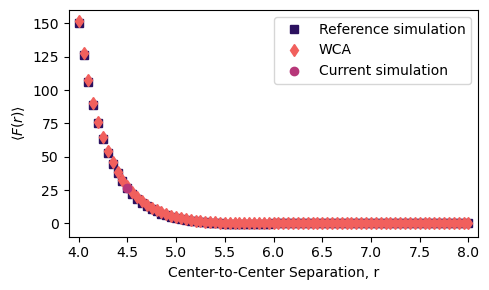

In [41]:
import matplotlib.pyplot as plt

# Create magma colormap
cmap = plt.cm.magma
colors = [cmap(i) for i in np.linspace(0, 1, 7)]  # 7 colors sampled evenly

plt.figure(figsize=(5, 3))

#Plot the force from the reference simulation
plt.plot(r_all, ForceAllx, marker='s', linestyle='none',color=colors[1], markersize=6, label='Reference simulation')
plt.plot(r_all, wcaAllx, marker='d', linestyle='none',color=colors[4], markersize=6, label='WCA')
#Plot the force from the current simulation
plt.plot(r, Force_Total, marker='o', linestyle='none', color=colors[3],label='Current simulation')

plt.xlim(3.9, 8.1)
plt.ylim(-10.0, 160.0)
plt.xlabel('Center-to-Center Separation, r')
plt.ylabel(r'$\langle F(r) \rangle$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Depletion forces = Average force - WCA force 

In [43]:
idx = np.argmin(np.abs(r-wcaAll[:,0]))
DepletionCal = Force_Total - wcaAll[idx,2]
print(DepletionCal)

-1.2049145088744808


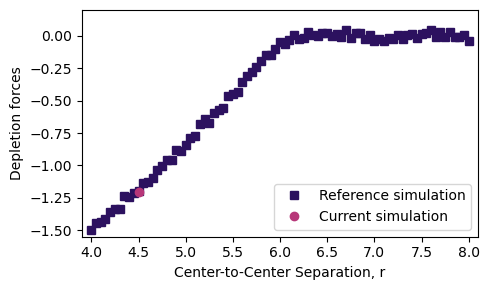

In [44]:
plt.figure(figsize=(5, 3))
#Plot the force from the reference simulation
plt.plot(r_all, Depletionx, marker='s', linestyle='none',color=colors[1], markersize=6, label='Reference simulation')
plt.plot(r, DepletionCal, marker='o', linestyle='none', color=colors[3],label='Current simulation')

plt.xlim(3.9, 8.1)
plt.ylim(-1.55, 0.2)
plt.xlabel('Center-to-Center Separation, r')
plt.ylabel(r'Depletion forces')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('force_vs_distance.png', transparent=True, dpi=300)
plt.show()

Potential of mean force is calculated by integrating avearge force

\begin{equation}
\text{PMF}(r) = - \int_{r_0}^{r} \langle F(r') \rangle \, dr'
\end{equation}

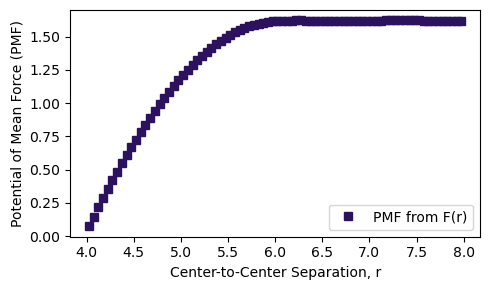

In [45]:
#  Compute PMF via trapezoidal integration 
pmf = np.zeros(len(ForceAllx))
avg_r = np.zeros(len(r_all)-1)

for i in range(1, len(r_all)):
    dr = r_all[i] - r_all[i - 1]
    avg_force = 0.5 * (Depletionx[i] + Depletionx[i - 1])
    avg_r[i-1] = r_all[i-1]+dr/2   #the average value is of r is taken as we are using trapezoidal rule
    pmf[i] = pmf[i - 1] - avg_force * dr

# ------- Plot PMF -------
plt.figure(figsize=(5, 3))
plt.plot(avg_r, pmf[1:], marker='s', linestyle='none',markersize=6,label='PMF from F(r)', color=colors[1])
plt.xlabel('Center-to-Center Separation, r')
plt.ylabel('Potential of Mean Force (PMF)')
plt.legend()
plt.tight_layout()
plt.show()


Normalize PMF to ensure as $r \to \infty$, PMF $\to 0$


In [46]:
flat_pmf = np.mean(pmf[60:])
pmf -= flat_pmf

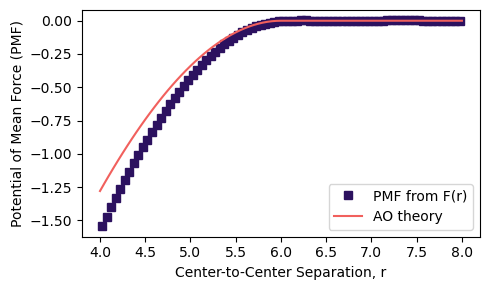

In [47]:
# ------- Plot PMF --------

def ao_potential(r, sigma_c, sigma_d, phi_d):
    R_c = sigma_c/2.0
    R_d = sigma_d/2.0
    R_s = R_c + R_d
    rcut = 2 * R_s
    U_AO = np.zeros_like(r)
    mask = r < rcut
    x = r[mask]
    U_AO[mask] = - (R_s/R_d)**3 * (1 - 3/4 * (x/R_s) + 1/16 * (x/R_s)**3) * phi_d

    return U_AO

AO = ao_potential(r_all, sigma_c, sigma_d, phi_d)

plt.figure(figsize=(5, 3))


plt.plot(avg_r, pmf[1:], marker='s',markersize=6,linestyle='none',label='PMF from F(r)', color=colors[1])
plt.plot(r_all, AO, marker='none', linestyle='-', label='AO theory', color=colors[4])
plt.xlabel('Center-to-Center Separation, r')
plt.ylabel('Potential of Mean Force (PMF)')
plt.legend()
plt.tight_layout()
plt.show()

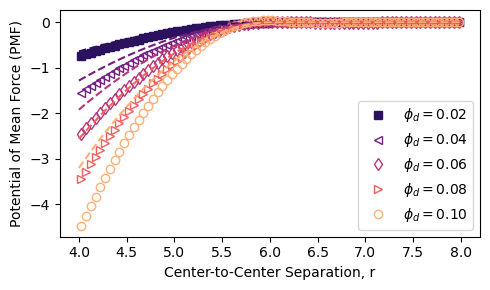

In [48]:
# Load the data 
phi02 = np.loadtxt('phi_0.02')
phi04 = np.loadtxt('phi_0.04')
phi06 = np.loadtxt('phi_0.06')
phi08 = np.loadtxt('phi_0.08')
phi10 = np.loadtxt('phi_0.1')
wcaAll = np.loadtxt('wca.txt')

r_all = phi02[:, 0]
phi02x = (phi02[:, 2] - phi02[:, 5])/2.0
phi04x = (phi04[:, 2] - phi04[:, 5])/2.0
phi06x = (phi06[:, 2] - phi06[:, 5])/2.0
phi08x = (phi08[:, 2] - phi08[:, 5])/2.0
phi10x = (phi10[:, 2] - phi10[:, 5])/2.0


wcaAllx = (wcaAll[:, 2] - wcaAll[:, 5])/2.0
phi02Depletion= phi02x-wcaAllx
phi04Depletion= phi04x-wcaAllx
phi06Depletion= phi06x-wcaAllx
phi08Depletion= phi08x-wcaAllx
phi10Depletion= phi10x-wcaAllx

#  Compute PMF via trapezoidal integration 
pmf02 = np.zeros(len(phi02x))
pmf04 = np.zeros(len(phi04x))
pmf06 = np.zeros(len(phi06x))
pmf08 = np.zeros(len(phi08x))
pmf10 = np.zeros(len(phi10x))
avg_r = np.zeros(len(r_all)-1)

for i in range(1, len(r_all)):
    dr = r_all[i] - r_all[i - 1]
    avg_force02 = 0.5 * (phi02Depletion[i] + phi02Depletion[i - 1])
    avg_force04 = 0.5 * (phi04Depletion[i] + phi04Depletion[i - 1])
    avg_force06 = 0.5 * (phi06Depletion[i] + phi06Depletion[i - 1])
    avg_force08 = 0.5 * (phi08Depletion[i] + phi08Depletion[i - 1])
    avg_force10 = 0.5 * (phi10Depletion[i] + phi10Depletion[i - 1])
    avg_r[i-1] = r_all[i-1]+dr/2   #the average value is of r is taken as we are using trapezoidal rule
    pmf02[i] = pmf02[i - 1] - avg_force02 * dr
    pmf04[i] = pmf04[i - 1] - avg_force04 * dr
    pmf06[i] = pmf06[i - 1] - avg_force06 * dr
    pmf08[i] = pmf08[i - 1] - avg_force08 * dr
    pmf10[i] = pmf10[i - 1] - avg_force10 * dr


flat_pmf02 = np.mean(pmf02[60:])
flat_pmf04 = np.mean(pmf04[60:])
flat_pmf06 = np.mean(pmf06[60:])
flat_pmf08 = np.mean(pmf08[60:])
flat_pmf10 = np.mean(pmf10[60:])

pmf02 -= flat_pmf02
pmf04 -= flat_pmf04
pmf06 -= flat_pmf06
pmf08 -= flat_pmf08
pmf10 -= flat_pmf10

def ao_potential(r, sigma_c, sigma_d, phi_d):
    R_c = sigma_c/2.0
    R_d = sigma_d/2.0
    R_s = R_c + R_d
    rcut = 2 * R_s
    U_AO = np.zeros_like(r)
    mask = r < rcut
    x = r[mask]
    U_AO[mask] = - (R_s/R_d)**3 * (1 - 3/4 * (x/R_s) + 1/16 * (x/R_s)**3) * phi_d

    return U_AO

AO02 = ao_potential(r_all, sigma_c, sigma_d, 0.02)
AO04 = ao_potential(r_all, sigma_c, sigma_d, 0.04)
AO06 = ao_potential(r_all, sigma_c, sigma_d, 0.06)
AO08 = ao_potential(r_all, sigma_c, sigma_d, 0.08)
AO10 = ao_potential(r_all, sigma_c, sigma_d, 0.10)

# ------- Plot PMF -------
plt.figure(figsize=(5, 3))
plt.plot(avg_r, pmf02[1:], marker='s', linestyle='none',markersize=6,label='$\phi_{d}=0.02$', color=colors[1])
plt.plot(avg_r, pmf04[1:], marker='<', linestyle='none',markersize=6, mfc='none',label='$\phi_{d}=0.04$', color=colors[2])
plt.plot(avg_r, pmf06[1:], marker='d', linestyle='none',markersize=6, mfc='none',label='$\phi_{d}=0.06$', color=colors[3])
plt.plot(avg_r, pmf08[1:], marker='>', linestyle='none',markersize=6, mfc='none',label='$\phi_{d}=0.08$', color=colors[4])
plt.plot(avg_r, pmf10[1:], marker='o', linestyle='none',markersize=6, mfc='none',label='$\phi_{d}=0.10$', color=colors[5])

plt.plot(r_all, AO02, marker='none', linestyle='--', color=colors[1])
plt.plot(r_all, AO04, marker='none', linestyle='--', color=colors[2])
plt.plot(r_all, AO06, marker='none', linestyle='--', color=colors[3])
plt.plot(r_all, AO08, marker='none', linestyle='--', color=colors[4])
plt.plot(r_all, AO10, marker='none', linestyle='--', color=colors[5])


plt.xlabel('Center-to-Center Separation, r')
plt.ylabel('Potential of Mean Force (PMF)')
plt.legend()
plt.tight_layout()
plt.show()

